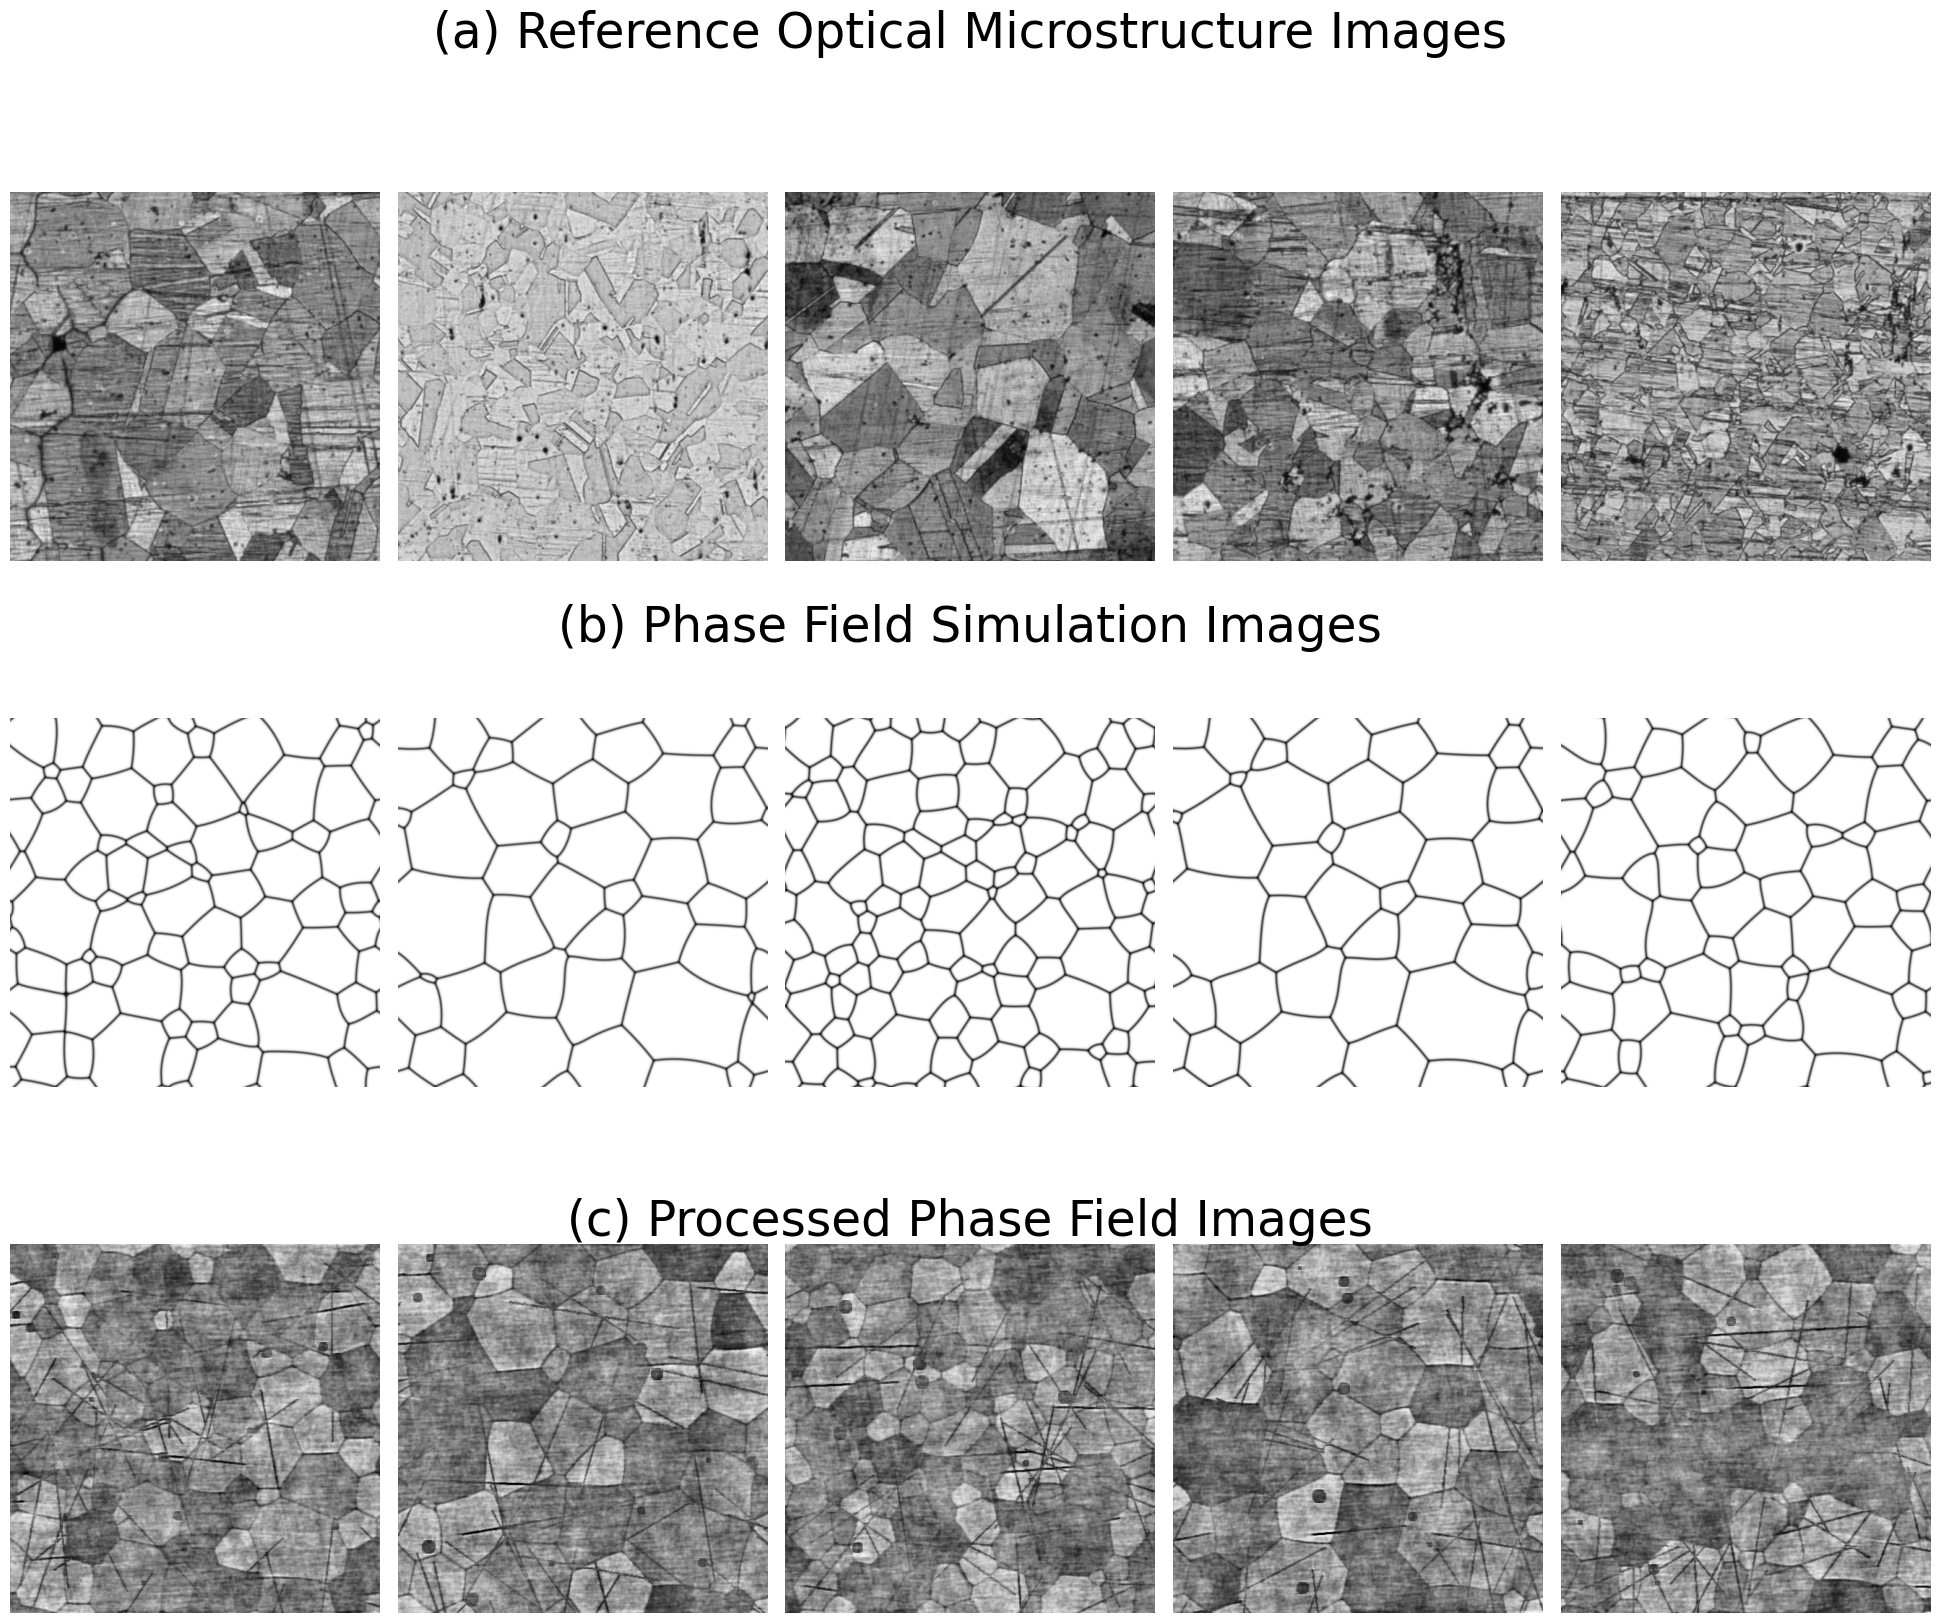

In [ ]:
import os
import numpy as np
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology
from scipy.ndimage import binary_fill_holes, gaussian_filter
from scipy.fftpack import fft2, ifft2
import random
import glob

# Set consistent font sizes globally
TITLE_SIZE = 35
LABEL_SIZE = 30
TICK_SIZE = 28

plt.rcParams.update({
    'font.size': LABEL_SIZE,
    'axes.labelsize': LABEL_SIZE,
    'axes.titlesize': TITLE_SIZE,
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE
})

def clean_and_normalize_data(data):
    data = np.nan_to_num(data)
    data = data.astype(float)
    min_val = np.min(data)
    max_val = np.max(data)
    
    if min_val == max_val:
        return np.zeros_like(data)
    
    return (data - min_val) / (max_val - min_val)

def fill_grains_with_random_intensities(image):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    filled = binary_fill_holes(binary)
    labeled = measure.label(filled)
    result = np.zeros_like(image)
    
    for label in range(1, labeled.max() + 1):
        grain_mask = labeled == label
        grain_mask = morphology.binary_dilation(grain_mask, morphology.disk(1))
        intensity = np.random.uniform(0.1, 0.9)
        result[grain_mask] = intensity
    
    result = gaussian_filter(result, sigma=1)
    return result

def add_features_preserve_histogram(image, num_lines=200, num_spots=20, max_spot_radius=10, dark_percentile=10):
    height, width = image.shape
    result = image.copy()
    mask = np.zeros_like(image, dtype=bool)
    
    # Add lines to mask
    for _ in range(num_lines):
        angle = np.random.uniform(0, np.pi)
        start_x = np.random.randint(0, width)
        start_y = np.random.randint(0, height)
        length = np.random.randint(width//4, width//2)
        end_x = int(start_x + length * np.cos(angle))
        end_y = int(start_y + length * np.sin(angle))
        
        rr, cc = line(start_y, start_x, end_y, end_x)
        mask_line = (rr >= 0) & (rr < height) & (cc >= 0) & (cc < width)
        temp_mask = np.zeros_like(mask, dtype=bool)
        temp_mask[rr[mask_line], cc[mask_line]] = True
        temp_mask = morphology.binary_dilation(temp_mask, morphology.disk(1))
        mask |= temp_mask

    # Add spots
    for _ in range(num_spots):
        center_y = np.random.randint(0, height)
        center_x = np.random.randint(0, width)
        radius = np.random.randint(1, max_spot_radius + 1)
        rr, cc = disk((center_y, center_x), radius)
        mask_spot = (rr >= 0) & (rr < height) & (cc >= 0) & (cc < width)
        mask[rr[mask_spot], cc[mask_spot]] = True

    dark_threshold = np.percentile(image, dark_percentile)
    dark_pixels = image[image <= dark_threshold]
    new_values = np.random.choice(dark_pixels, size=np.sum(mask))
    result[mask] = new_values

    return result

def match_fourier_spectrum(source, target):
    source_fft = fft2(source)
    target_fft = fft2(target)
    
    source_amp, source_phase = np.abs(source_fft), np.angle(source_fft)
    target_amp = np.abs(target_fft)
    
    new_fft = target_amp * np.exp(1j * source_phase)
    matched = np.real(ifft2(new_fft))
    
    matched = (matched - matched.min()) / (matched.max() - matched.min())
    return matched

def match_histograms(source, template):
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()
    
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    return interp_t_values[bin_idx].reshape(oldshape)

# Directories
phase_field_dir = "/home/phase_evol/gg_512x512"
optical_dir = "/home/phase_evol/microstructures/dirty/"

# Load phase field files
phase_field_files = glob.glob(os.path.join(phase_field_dir, "*.dat"))
selected_phase_files = random.sample(phase_field_files, 5)

# Load optical microstructure files
optical_files = glob.glob(os.path.join(optical_dir, "*.png"))
selected_optical_files = random.sample(optical_files, 5)

# Load and process images
phase_field_images = []
optical_images = []
hist_matched_images = []

# Process phase field images
for pf_file in selected_phase_files:
    gg = np.genfromtxt(pf_file)
    gg_normalized = clean_and_normalize_data(gg)
    phase_field_images.append(gg_normalized)

# Process optical images
for opt_file in selected_optical_files:
    img = Image.open(opt_file).convert('L')
    img_array = np.array(img) / 255.0
    optical_images.append(img_array)

# Create processed images - all matched against first optical image
reference_image = optical_images[0]
for pf_img in phase_field_images:
    # Process chain
    filled = fill_grains_with_random_intensities(pf_img)
    noisy = add_features_preserve_histogram(filled, num_lines=50, num_spots=20, max_spot_radius=10)
    fft_matched = match_fourier_spectrum(noisy, reference_image)
    hist_matched = match_histograms(fft_matched, reference_image)
    hist_matched_images.append(hist_matched)

# Create visualization
fig = plt.figure(figsize=(20, 18))
gs = plt.GridSpec(3, 5, height_ratios=[1, 1, 1])

# Prepare image sets and titles
image_sets = [
    (optical_images, 'Reference Optical Microstructure Images'),
    (phase_field_images, 'Phase Field Simulation Images'),
    (hist_matched_images, 'Processed Phase Field Images')
]

# Plot images
for row, (images, row_label) in enumerate(image_sets):
    # Add centered row label
    fig.text(0.5, 0.95 - row * 0.33, f'({chr(97 + row)}) {row_label}', 
             fontsize=TITLE_SIZE, horizontalalignment='center')
    
    for col in range(5):
        ax = fig.add_subplot(gs[row, col])
        img = images[col]
        ax.imshow(img, cmap='gray')
        ax.axis('off')

plt.subplots_adjust(top=0.9, bottom=0.05, left=0.02, right=0.98, hspace=0.1, wspace=0.05)
# plt.savefig("microstructure_comparison.png", bbox_inches='tight', pad_inches=0.05, dpi=300)
plt.show()

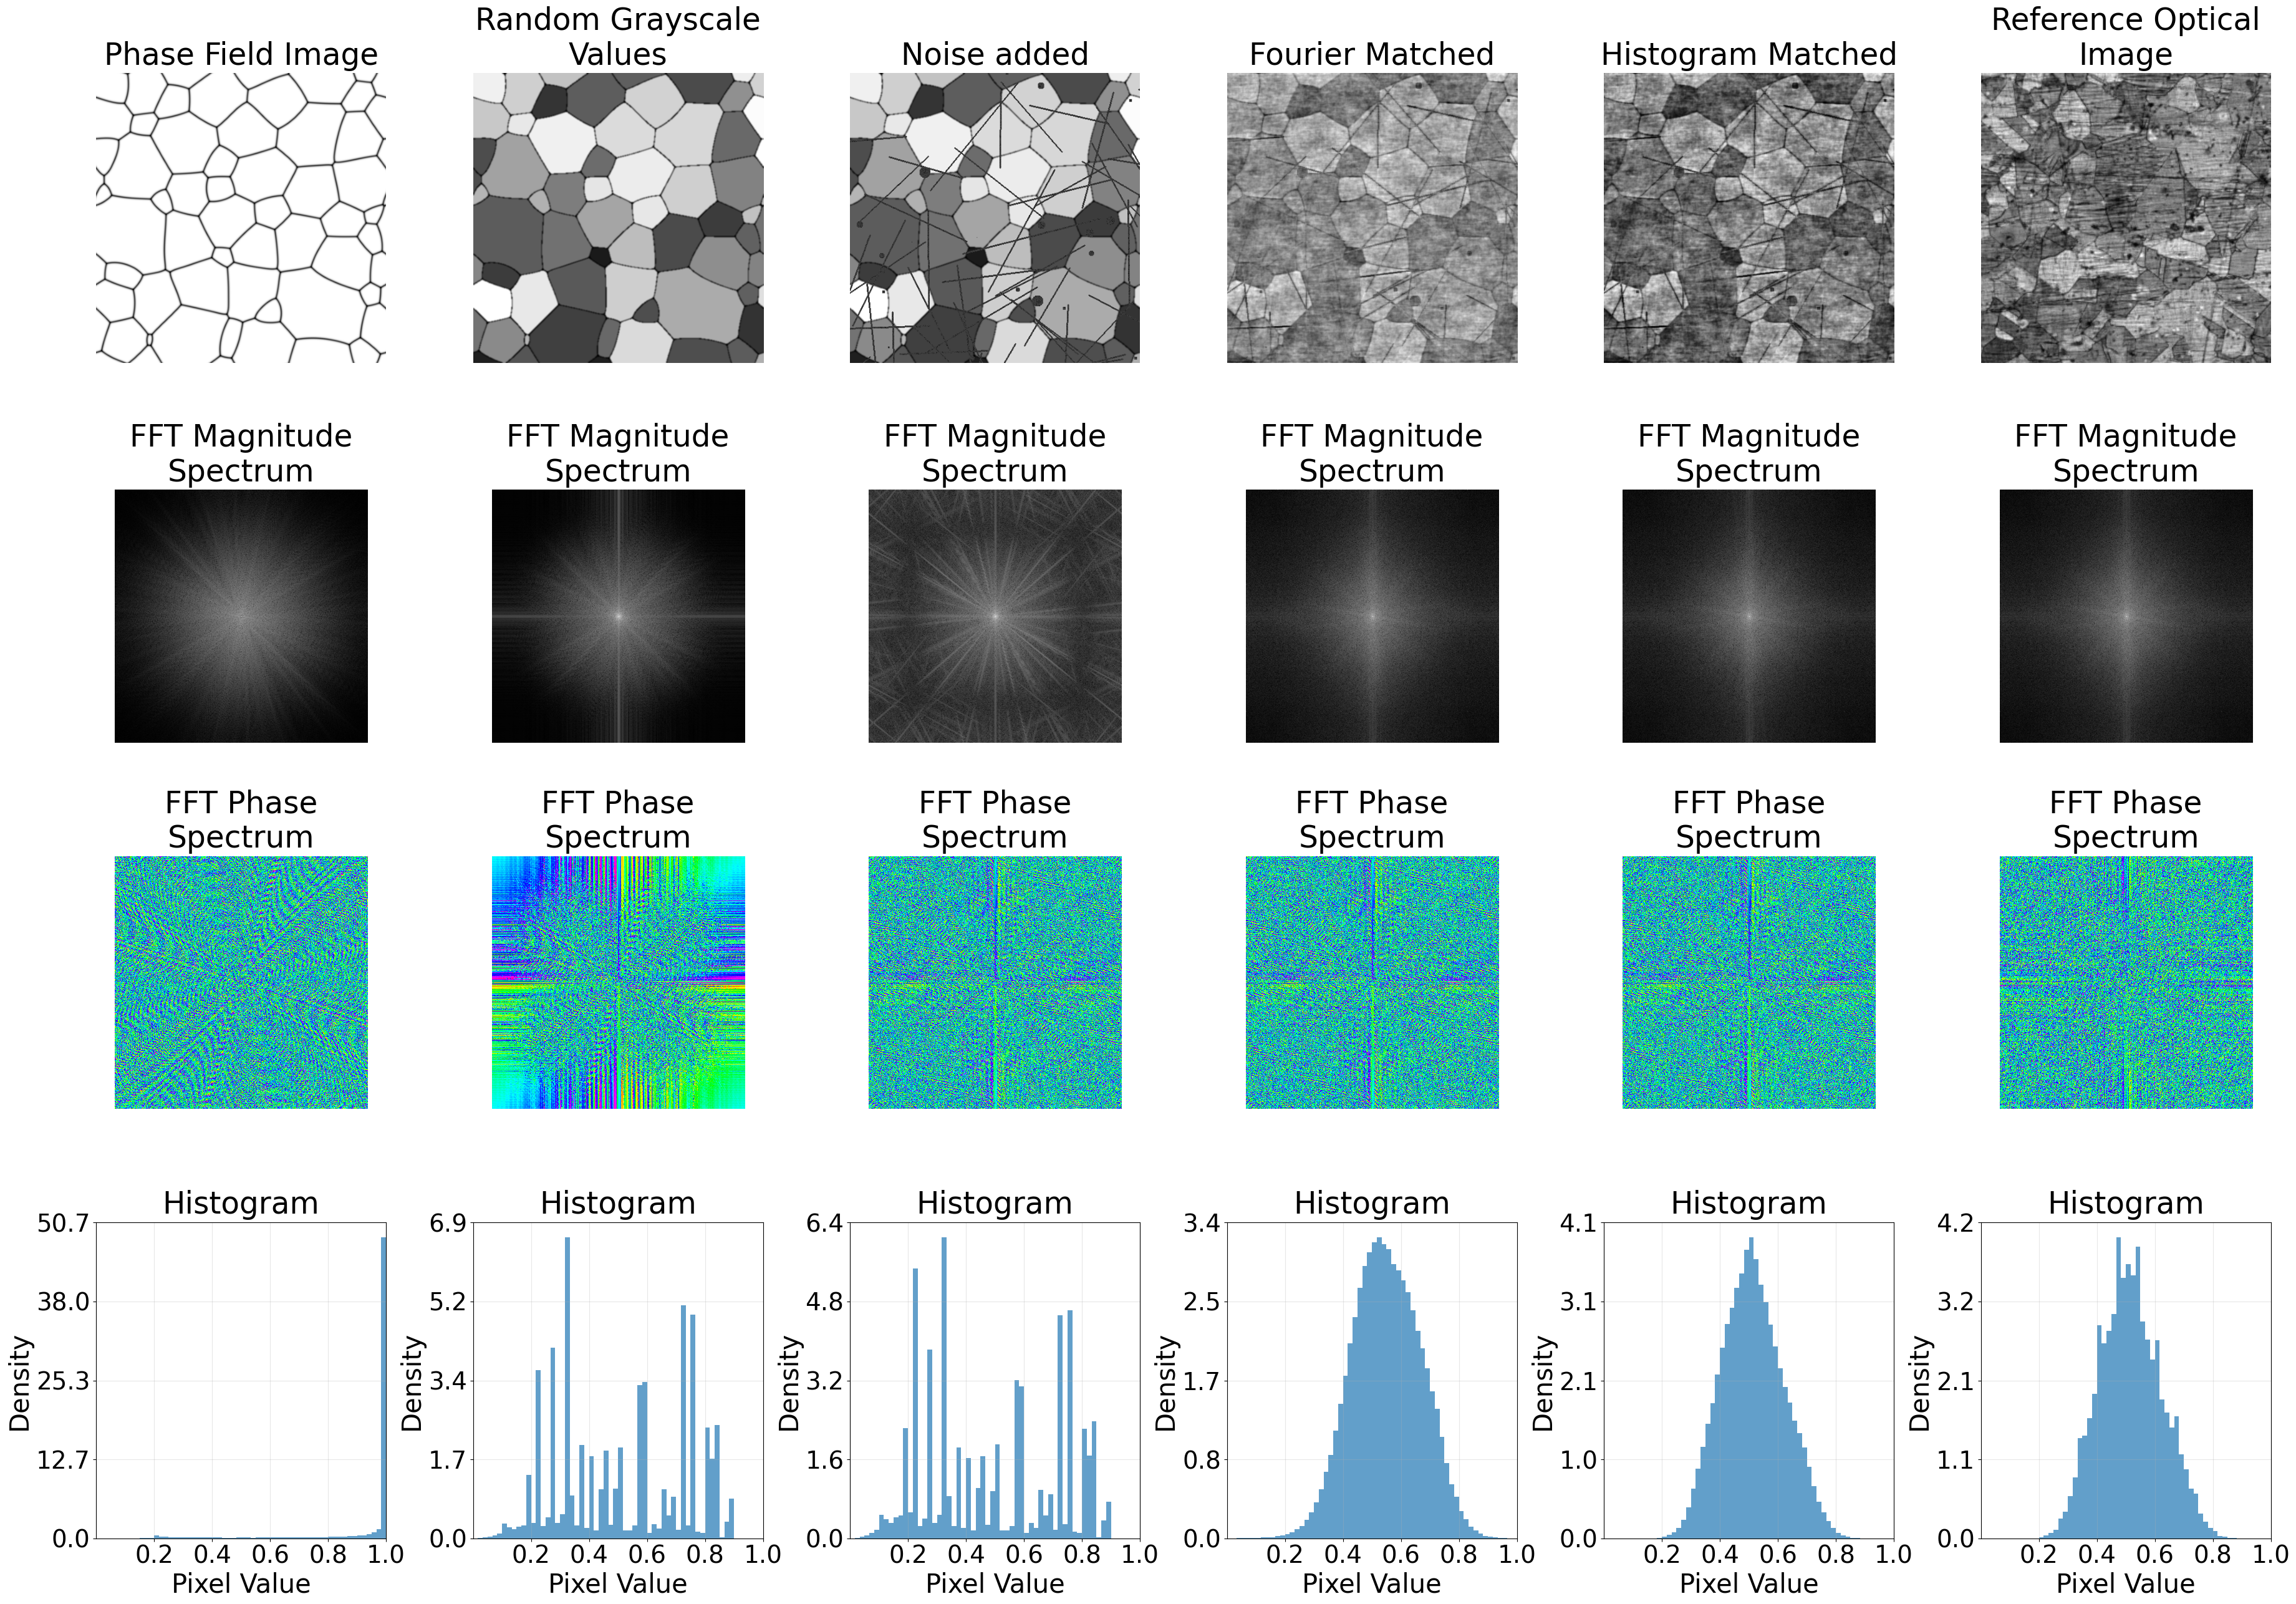

In [ ]:
import os
import numpy as np
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology
from scipy.ndimage import binary_fill_holes, gaussian_filter
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage.draw import line, disk

# Set consistent font sizes globally
TITLE_SIZE = 35
LABEL_SIZE = 30
TICK_SIZE = 28

plt.rcParams.update({
    'font.size': LABEL_SIZE,
    'axes.labelsize': LABEL_SIZE,
    'axes.titlesize': TITLE_SIZE,
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE
})

def clean_and_normalize_data(data):
    data = np.nan_to_num(data)
    data = data.astype(float)
    min_val = np.min(data)
    max_val = np.max(data)
    
    if min_val == max_val:
        return np.zeros_like(data)
    
    return (data - min_val) / (max_val - min_val)

def fill_grains_with_random_intensities(image):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    filled = binary_fill_holes(binary)
    labeled = measure.label(filled)
    result = np.zeros_like(image)
    
    for label in range(1, labeled.max() + 1):
        grain_mask = labeled == label
        grain_mask = morphology.binary_dilation(grain_mask, morphology.disk(1))
        intensity = np.random.uniform(0.1, 0.9)
        result[grain_mask] = intensity
    
    result = gaussian_filter(result, sigma=1)
    return result

def add_features_preserve_histogram(image, num_lines=200, num_spots=20, max_spot_radius=10, dark_percentile=10):
    height, width = image.shape
    result = image.copy()
    
    # Create a mask for lines and spots
    mask = np.zeros_like(image, dtype=bool)
    
    # Add lines to mask with increased thickness for continuity
    for _ in range(num_lines):
        angle = np.random.uniform(0, np.pi)
        start_x = np.random.randint(0, width)
        start_y = np.random.randint(0, height)
        length = np.random.randint(width//4, width//2)
        end_x = int(start_x + length * np.cos(angle))
        end_y = int(start_y + length * np.sin(angle))
        
        # Draw thicker line using morphological dilation
        rr, cc = line(start_y, start_x, end_y, end_x)
        mask_line = (rr >= 0) & (rr < height) & (cc >= 0) & (cc < width)
        temp_mask = np.zeros_like(mask, dtype=bool)
        temp_mask[rr[mask_line], cc[mask_line]] = True
        # Dilate the line to make it thicker and more continuous
        temp_mask = morphology.binary_dilation(temp_mask, morphology.disk(1))
        mask |= temp_mask

    # Add spots to mask
    for _ in range(num_spots):
        center_y = np.random.randint(0, height)
        center_x = np.random.randint(0, width)
        radius = np.random.randint(1, max_spot_radius + 1)
        rr, cc = disk((center_y, center_x), radius)
        mask_spot = (rr >= 0) & (rr < height) & (cc >= 0) & (cc < width)
        mask[rr[mask_spot], cc[mask_spot]] = True

    # Calculate the threshold for dark pixels
    dark_threshold = np.percentile(image, dark_percentile)
    
    # Get the pixel values below the dark threshold
    dark_pixels = image[image <= dark_threshold]
    
    # Generate new values for the masked areas from the dark pixels
    new_values = np.random.choice(dark_pixels, size=np.sum(mask))
    
    # Replace the masked pixels with the new values
    result[mask] = new_values

    return result

def match_histograms(source, template):
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()
    
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    return interp_t_values[bin_idx].reshape(oldshape)

def match_fourier_spectrum(source, target):
    source_fft = fft2(source)
    target_fft = fft2(target)
    
    source_amp, source_phase = np.abs(source_fft), np.angle(source_fft)
    target_amp = np.abs(target_fft)
    
    new_fft = target_amp * np.exp(1j * source_phase)
    matched = np.real(ifft2(new_fft))
    
    matched = (matched - matched.min()) / (matched.max() - matched.min())
    return matched

def plot_fft_with_phase(img, ax_magnitude, ax_phase):
    f_transform = fft2(img)
    f_transform_shifted = fftshift(f_transform)
    
    # # Plot FFT (new)
    # im_fft = ax_fft.imshow(np.abs(f_transform_shifted), cmap='gray')
    # ax_fft.set_title('FFT', fontsize=TITLE_SIZE, pad=10)
    # ax_fft.axis('off')
    
    # Plot Magnitude spectrum
    magnitude = np.log10(np.abs(f_transform_shifted) + 1)
    im_mag = ax_magnitude.imshow(magnitude, cmap='gray')
    ax_magnitude.set_title('FFT Magnitude\nSpectrum', fontsize=TITLE_SIZE, pad=10)
    ax_magnitude.axis('off')
    
    # Plot Phase spectrum
    phase = np.angle(f_transform_shifted)
    im_phase = ax_phase.imshow(phase, cmap='hsv')
    ax_phase.set_title('FFT Phase\nSpectrum', fontsize=TITLE_SIZE, pad=10)
    ax_phase.axis('off')
    
    return im_mag, im_phase

def create_wrapped_title(title, width=20):
    return '\n'.join(wrap(title, width=width))

# Load and process data
dat_directory = "/home/phase_evol/gg_512x512"
dat_file = "time_400.dat"
reference_path = "/home/512x512_patches/ann-50x 0027_patch_x512_y411.png"

# Load phase field data
dat_path = os.path.join(dat_directory, dat_file)
gg = np.genfromtxt(dat_path)
gg_normalized = clean_and_normalize_data(gg)

# Load reference image
reference_image = Image.open(reference_path).convert('L')
reference_array = np.array(reference_image)
reference_normalized = reference_array / 255.0

# Process images
gg_filled = fill_grains_with_random_intensities(gg_normalized)
gg_final = add_features_preserve_histogram(gg_filled, num_lines=50, num_spots=20, max_spot_radius=10)
gg_final_matched = match_fourier_spectrum(gg_final, reference_normalized)
gg_final_matched_hist = match_histograms(gg_final_matched, reference_normalized)

# Prepare visualization
images = [gg_normalized, gg_filled, gg_final, gg_final_matched, gg_final_matched_hist, reference_normalized]
titles = ['Phase Field Image', 'Random Grayscale Values', 'Noise added', 
          'Fourier Matched', 'Histogram Matched', 'Reference Optical Image']

# Create visualization
fig = plt.figure(figsize=(45, 30))  # Adjusted height
gs = plt.GridSpec(4, 6, height_ratios=[1, 0.8, 0.8, 1])  # 4 rows now

# Add column labels
# column_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Plot original images
for i, (img, title) in enumerate(zip(images, titles)):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(img, cmap='gray')
    full_title = f'{create_wrapped_title(title)}'
    ax.set_title(full_title, fontsize=TITLE_SIZE, pad=10)
    ax.axis('off')

# Plot magnitude and phase
for i, img in enumerate(images):
    ax_mag = fig.add_subplot(gs[1, i])  # Magnitude plot
    ax_phase = fig.add_subplot(gs[2, i])  # Phase plot
    plot_fft_with_phase(img, ax_mag, ax_phase)

# Plot histograms with fixed x-axis scaling
for i, img in enumerate(images):
    ax = fig.add_subplot(gs[3, i])
    
    # Plot histogram
    ax.hist(img.ravel(), bins=60, density=True, alpha=0.7, range=(0, 1))
    ax.grid(True, alpha=0.3)
    
    # Set consistent x-axis limits
    ax.set_xlim(0, 1)
    
    # Add title and labels for all histograms
    ax.set_title('Histogram', fontsize=TITLE_SIZE, pad=10)
    ax.set_xlabel('Pixel Value', fontsize=LABEL_SIZE)
    ax.set_ylabel('Density', fontsize=LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    
    # Fix x-axis ticks (single zero)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    xticklabels = ['0.2', '0.4', '0.6', '0.8', '1.0']
    ax.set_xticklabels(xticklabels)
    
    # Fix y-axis ticks to show more values
    yticks = np.linspace(0, ax.get_ylim()[1], 5)  # 5 evenly spaced ticks
    ax.set_yticks(yticks)
    yticklabels = [f'{y:.1f}' for y in yticks]
    ax.set_yticklabels(yticklabels)

plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
# plt.savefig("fig1_withphase.png",  bbox_inches='tight', pad_inches=0.05, dpi=100)
plt.show()